In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


### Loading Starting Moneyline Data

In [6]:
df = pd.read_parquet('s3://moneygans-data/basketball_nba/starting_money/starting_money_agg/starting_money_all.parquet', engine='pyarrow')
df[['pos_money','neg_money']]

,pos_money,neg_money
0,380,-500
1,340,-500
2,400,-550
3,400,-550
4,400,-525
...,...,...
31,400,-520
32,375,-500
33,400,-550
34,340,-450


### Initial Network

Epoch 0, Loss C: -0.0777, Loss G: 0.0097
Epoch 500, Loss C: -0.0313, Loss G: 0.0023
Epoch 1000, Loss C: -0.0397, Loss G: 0.1375
Epoch 1500, Loss C: -0.0439, Loss G: 0.0428
Epoch 2000, Loss C: -0.0244, Loss G: 0.0264
Epoch 2500, Loss C: -0.0345, Loss G: 0.0647
Epoch 3000, Loss C: 0.0005, Loss G: 0.0150
Epoch 3500, Loss C: -0.0066, Loss G: 0.0247
Epoch 4000, Loss C: -0.0264, Loss G: 0.1207
Epoch 4500, Loss C: -0.0091, Loss G: 0.0727


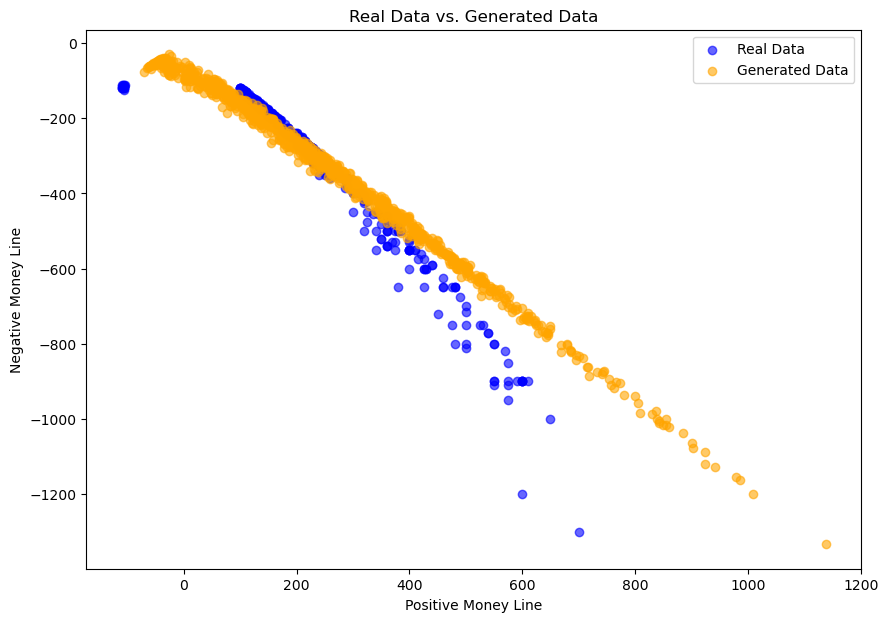

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load your data into a pandas DataFrame
# Ensure 'df' is your DataFrame with columns 'pos_money' and 'neg_money'
# For example:
# df = pd.read_csv('your_data.csv')

# Extract the data from the DataFrame
data = df[['pos_money', 'neg_money']].values.astype(np.float32)

# Convert data to PyTorch tensor
real_data = torch.tensor(data)

# Create a PyTorch dataset and dataloader
batch_size = 64  # Adjust batch size as needed
dataset = TensorDataset(real_data)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Define the Generator network
class Generator(nn.Module):
    def __init__(self, noise_dim=10, output_dim=2):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(noise_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim),
        )

    def forward(self, z):
        return self.model(z)

# Define the Critic network
class Critic(nn.Module):
    def __init__(self, input_dim=2):
        super(Critic, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 64),
            nn.LeakyReLU(0.2),
            nn.Linear(64, 1),
        )

    def forward(self, x):
        return self.model(x)

# Hyperparameters
noise_dim = 10
n_epochs = 5000  # Increase epochs for better results
lr = 1e-4
n_critic = 5  # Number of critic iterations per generator iteration
weight_clip = 0.01

# Initialize models and optimizers
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
G = Generator(noise_dim=noise_dim, output_dim=2).to(device)
C = Critic(input_dim=2).to(device)

optimizer_G = optim.RMSprop(G.parameters(), lr=lr)
optimizer_C = optim.RMSprop(C.parameters(), lr=lr)

# Training loop
for epoch in range(n_epochs):
    for i, data in enumerate(dataloader):
        real_samples = data[0].to(device)
        batch_size = real_samples.size(0)

        # Train Critic
        for _ in range(n_critic):
            z = torch.randn(batch_size, noise_dim).to(device)
            fake_samples = G(z).detach()

            critic_real = C(real_samples)
            critic_fake = C(fake_samples)

            loss_C = -(torch.mean(critic_real) - torch.mean(critic_fake))

            optimizer_C.zero_grad()
            loss_C.backward()
            optimizer_C.step()

            # Weight clipping
            for p in C.parameters():
                p.data.clamp_(-weight_clip, weight_clip)

        # Train Generator
        z = torch.randn(batch_size, noise_dim).to(device)
        fake_samples = G(z)
        critic_fake = C(fake_samples)
        loss_G = -torch.mean(critic_fake)

        optimizer_G.zero_grad()
        loss_G.backward()
        optimizer_G.step()

    if epoch % 500 == 0:
        print(f"Epoch {epoch}, Loss C: {loss_C.item():.4f}, Loss G: {loss_G.item():.4f}")

# Generate synthetic data
with torch.no_grad():
    z = torch.randn(1000, noise_dim).to(device)
    generated_samples = G(z).cpu().numpy()

# Plot real data vs. generated data
real_data_np = real_data.numpy()

plt.figure(figsize=(10, 7))
plt.scatter(real_data_np[:, 0], real_data_np[:, 1], label='Real Data', color='blue', alpha=0.6)
plt.scatter(generated_samples[:, 0], generated_samples[:, 1], label='Generated Data', color='orange', alpha=0.6)
plt.title('Real Data vs. Generated Data')
plt.xlabel('Positive Money Line')
plt.ylabel('Negative Money Line')
plt.legend()
plt.show()


### More complex network using batch normalization

Epoch 0, Loss C: -0.0000, Loss G: 0.0090
Epoch 500, Loss C: -0.0069, Loss G: 0.0061
Epoch 1000, Loss C: -0.0066, Loss G: 0.0112
Epoch 1500, Loss C: -0.0000, Loss G: -0.0011
Epoch 2000, Loss C: -0.0001, Loss G: 0.0011
Epoch 2500, Loss C: 0.0004, Loss G: 0.0048
Epoch 3000, Loss C: 0.0000, Loss G: 0.0160
Epoch 3500, Loss C: -0.0003, Loss G: 0.0069
Epoch 4000, Loss C: -0.0007, Loss G: 0.0134
Epoch 4500, Loss C: -0.0000, Loss G: 0.0158


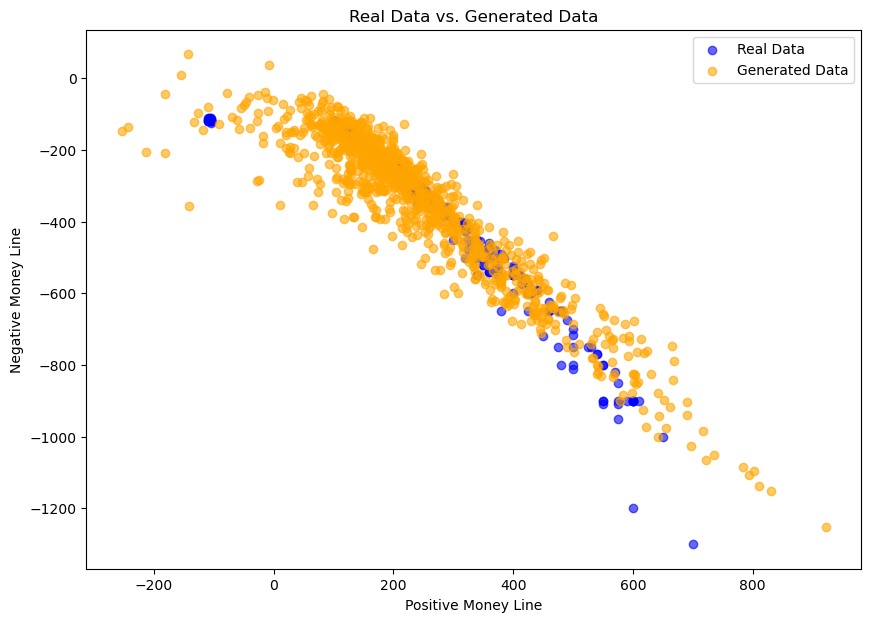

In [ ]:
# Load your data into a pandas DataFrame
# Ensure 'df' is your DataFrame with columns 'pos_money' and 'neg_money'
# For example:
# df = pd.read_csv('your_data.csv')

# Extract the data from the DataFrame
data = df[['pos_money', 'neg_money']].values.astype(np.float32)

# (Optional) Normalize the data for better training stability
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
data = scaler.fit_transform(data)

# Convert data to PyTorch tensor
real_data = torch.tensor(data)

# Create a PyTorch dataset and dataloader
batch_size = 64  # Adjust batch size as needed
dataset = TensorDataset(real_data)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Define the Generator network with Batch Normalization and more layers
class Generator(nn.Module):
    def __init__(self, noise_dim=10, output_dim=2):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(noise_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, output_dim),
        )

    def forward(self, z):
        return self.model(z)

# Define the Critic network with Batch Normalization and more layers
class Critic(nn.Module):
    def __init__(self, input_dim=2):
        super(Critic, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.LayerNorm(128),  # Use LayerNorm in Critic as per WGAN guidelines
            nn.LeakyReLU(0.2),
            nn.Linear(128, 256),
            nn.LayerNorm(256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 128),
            nn.LayerNorm(128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 1),
        )

    def forward(self, x):
        return self.model(x)

# Hyperparameters
noise_dim = 10
n_epochs = 5000  # Increase epochs for better results
lr = 1e-4
n_critic = 5  # Number of critic iterations per generator iteration
weight_clip = 0.01

# Initialize models and optimizers
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
G = Generator(noise_dim=noise_dim, output_dim=2).to(device)
C = Critic(input_dim=2).to(device)

optimizer_G = optim.RMSprop(G.parameters(), lr=lr)
optimizer_C = optim.RMSprop(C.parameters(), lr=lr)

# Training loop
for epoch in range(n_epochs):
    for i, data in enumerate(dataloader):
        real_samples = data[0].to(device)
        batch_size = real_samples.size(0)

        # Train Critic
        for _ in range(n_critic):
            z = torch.randn(batch_size, noise_dim).to(device)
            fake_samples = G(z).detach()

            critic_real = C(real_samples)
            critic_fake = C(fake_samples)

            loss_C = -(torch.mean(critic_real) - torch.mean(critic_fake))

            optimizer_C.zero_grad()
            loss_C.backward()
            optimizer_C.step()

            # Weight clipping
            for p in C.parameters():
                p.data.clamp_(-weight_clip, weight_clip)

        # Train Generator
        z = torch.randn(batch_size, noise_dim).to(device)
        fake_samples = G(z)
        critic_fake = C(fake_samples)
        loss_G = -torch.mean(critic_fake)

        optimizer_G.zero_grad()
        loss_G.backward()
        optimizer_G.step()

    if epoch % 500 == 0:
        print(f"Epoch {epoch}, Loss C: {loss_C.item():.4f}, Loss G: {loss_G.item():.4f}")

# Generate synthetic data
with torch.no_grad():
    z = torch.randn(1000, noise_dim).to(device)
    generated_samples = G(z).cpu().numpy()

# Inverse transform the data if normalized
generated_samples = scaler.inverse_transform(generated_samples)
real_data_np = scaler.inverse_transform(real_data.numpy())

# Plot real data vs. generated data
plt.figure(figsize=(10, 7))
plt.scatter(real_data_np[:, 0], real_data_np[:, 1], label='Real Data', color='blue', alpha=0.6)
plt.scatter(generated_samples[:, 0], generated_samples[:, 1], label='Generated Data', color='orange', alpha=0.6)
plt.title('Real Data vs. Generated Data')
plt.xlabel('Positive Money Line')
plt.ylabel('Negative Money Line')
plt.legend()
plt.show()


### Using Spectral Normalization

Epoch 0, Loss C: -0.0950, Loss G: 0.1064
Epoch 500, Loss C: -0.0038, Loss G: -0.1683
Epoch 1000, Loss C: -0.0072, Loss G: -0.1378
Epoch 1500, Loss C: -0.0022, Loss G: -0.0899
Epoch 2000, Loss C: -0.0041, Loss G: -0.0557
Epoch 2500, Loss C: -0.0031, Loss G: -0.0389
Epoch 3000, Loss C: -0.0050, Loss G: -0.0055
Epoch 3500, Loss C: -0.0030, Loss G: 0.0119
Epoch 4000, Loss C: -0.0029, Loss G: 0.0230
Epoch 4500, Loss C: -0.0023, Loss G: 0.0507


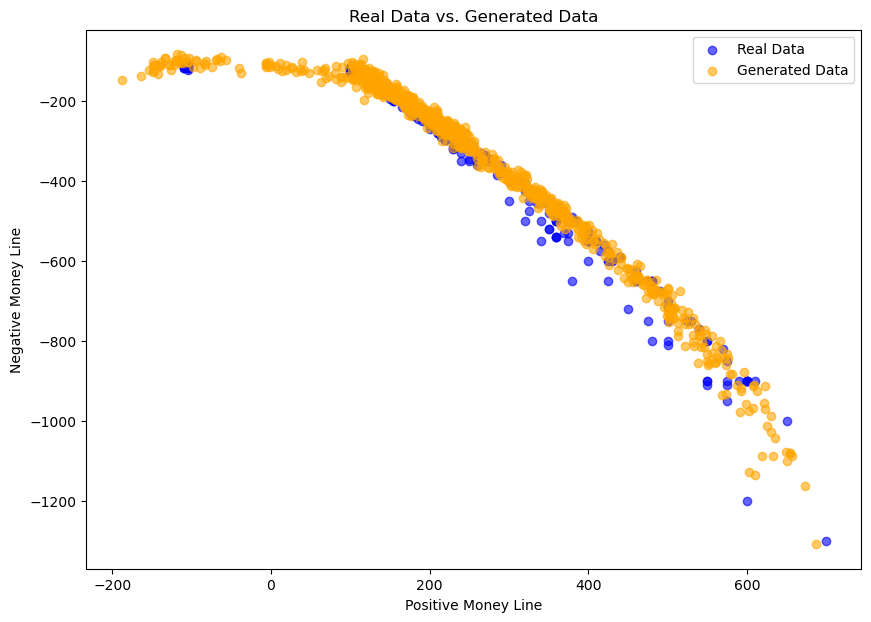

In [ ]:
# Load your data into a pandas DataFrame
# Ensure 'df' is your DataFrame with columns 'pos_money' and 'neg_money'
# For example:
# df = pd.read_csv('your_data.csv')

# Extract the data from the DataFrame
data = df[['pos_money', 'neg_money']].values.astype(np.float32)

# (Optional) Normalize the data for better training stability
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
data = scaler.fit_transform(data)

# Convert data to PyTorch tensor
real_data = torch.tensor(data)

# Create a PyTorch dataset and dataloader
batch_size = 64  # Adjust batch size as needed
dataset = TensorDataset(real_data)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Define the Generator network with Batch Normalization and more layers
class Generator(nn.Module):
    def __init__(self, noise_dim=10, output_dim=2):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(noise_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Linear(128, output_dim),
        )

    def forward(self, z):
        return self.model(z)

# Define the Critic network with Spectral Normalization and more layers
class Critic(nn.Module):
    def __init__(self, input_dim=2):
        super(Critic, self).__init__()
        self.model = nn.Sequential(
            nn.utils.spectral_norm(nn.Linear(input_dim, 128)),
            nn.LeakyReLU(0.2, inplace=True),
            nn.utils.spectral_norm(nn.Linear(128, 256)),
            nn.LeakyReLU(0.2, inplace=True),
            nn.utils.spectral_norm(nn.Linear(256, 128)),
            nn.LeakyReLU(0.2, inplace=True),
            nn.utils.spectral_norm(nn.Linear(128, 1)),
        )

    def forward(self, x):
        return self.model(x)

# Hyperparameters
noise_dim = 10
n_epochs = 5000  # Increase epochs for better results
lr = 1e-4
n_critic = 5  # Number of critic iterations per generator iteration

# Initialize models and optimizers
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
G = Generator(noise_dim=noise_dim, output_dim=2).to(device)
C = Critic(input_dim=2).to(device)

optimizer_G = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.9))
optimizer_C = optim.Adam(C.parameters(), lr=lr, betas=(0.5, 0.9))

# Training loop
for epoch in range(n_epochs):
    for i, data in enumerate(dataloader):
        real_samples = data[0].to(device)
        batch_size = real_samples.size(0)

        # Train Critic
        for _ in range(n_critic):
            z = torch.randn(batch_size, noise_dim).to(device)
            fake_samples = G(z).detach()

            critic_real = C(real_samples)
            critic_fake = C(fake_samples)

            loss_C = -(torch.mean(critic_real) - torch.mean(critic_fake))

            optimizer_C.zero_grad()
            loss_C.backward()
            optimizer_C.step()

        # Train Generator
        z = torch.randn(batch_size, noise_dim).to(device)
        fake_samples = G(z)
        critic_fake = C(fake_samples)
        loss_G = -torch.mean(critic_fake)

        optimizer_G.zero_grad()
        loss_G.backward()
        optimizer_G.step()

    if epoch % 500 == 0:
        print(f"Epoch {epoch}, Loss C: {loss_C.item():.4f}, Loss G: {loss_G.item():.4f}")

# Generate synthetic data
with torch.no_grad():
    z = torch.randn(1000, noise_dim).to(device)
    generated_samples = G(z).cpu().numpy()

# Inverse transform the data if normalized
generated_samples = scaler.inverse_transform(generated_samples)
real_data_np = scaler.inverse_transform(real_data.numpy())

# Plot real data vs. generated data
plt.figure(figsize=(10, 7))
plt.scatter(real_data_np[:, 0], real_data_np[:, 1], label='Real Data', color='blue', alpha=0.6)
plt.scatter(generated_samples[:, 0], generated_samples[:, 1], label='Generated Data', color='orange', alpha=0.6)
plt.title('Real Data vs. Generated Data')
plt.xlabel('Positive Money Line')
plt.ylabel('Negative Money Line')
plt.legend()
plt.show()


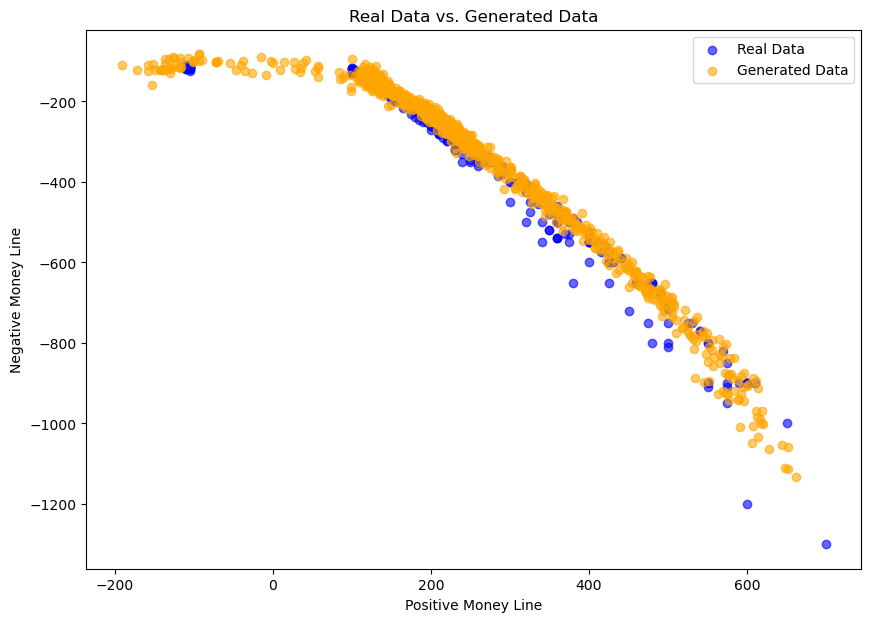

In [9]:
# Generate synthetic data
with torch.no_grad():
    z = torch.randn(1000, noise_dim).to(device)
    generated_samples = G(z).cpu().numpy()

# Inverse transform the data if normalized
generated_samples = scaler.inverse_transform(generated_samples)
real_data_np = scaler.inverse_transform(real_data.numpy())

# Plot real data vs. generated data
plt.figure(figsize=(10, 7))
plt.scatter(real_data_np[:, 0], real_data_np[:, 1], label='Real Data', color='blue', alpha=0.6)
plt.scatter(generated_samples[:, 0], generated_samples[:, 1], label='Generated Data', color='orange', alpha=0.6)
plt.title('Real Data vs. Generated Data')
plt.xlabel('Positive Money Line')
plt.ylabel('Negative Money Line')
plt.legend()
plt.show()


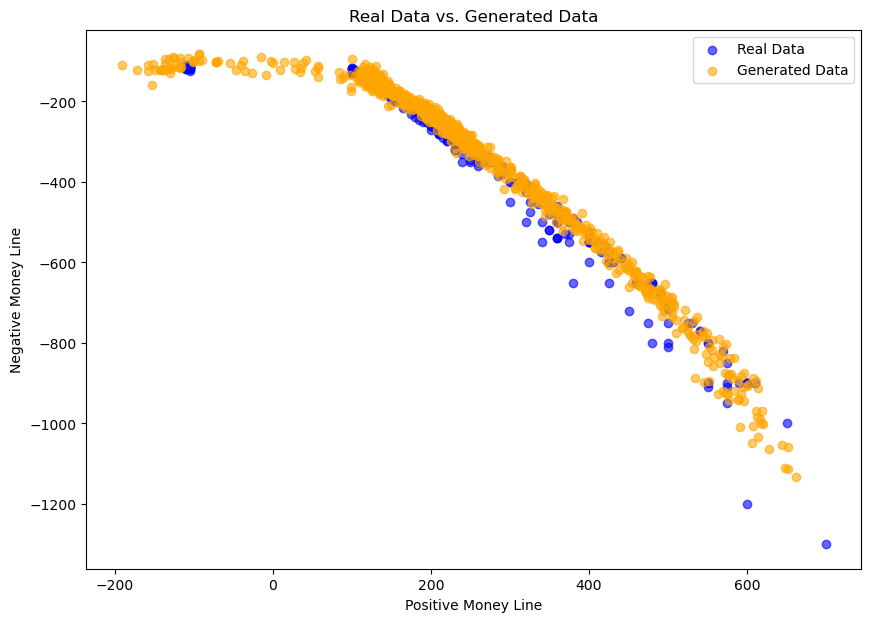

/Users/jake/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/jake/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/jake/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/jake/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version

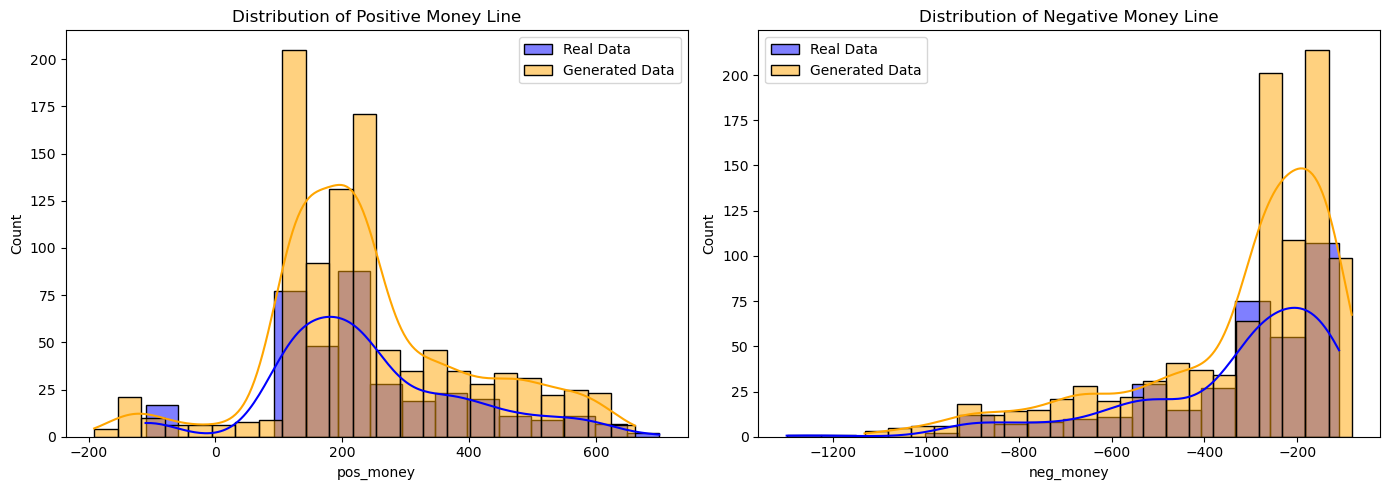

/Users/jake/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/jake/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/jake/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/jake/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version

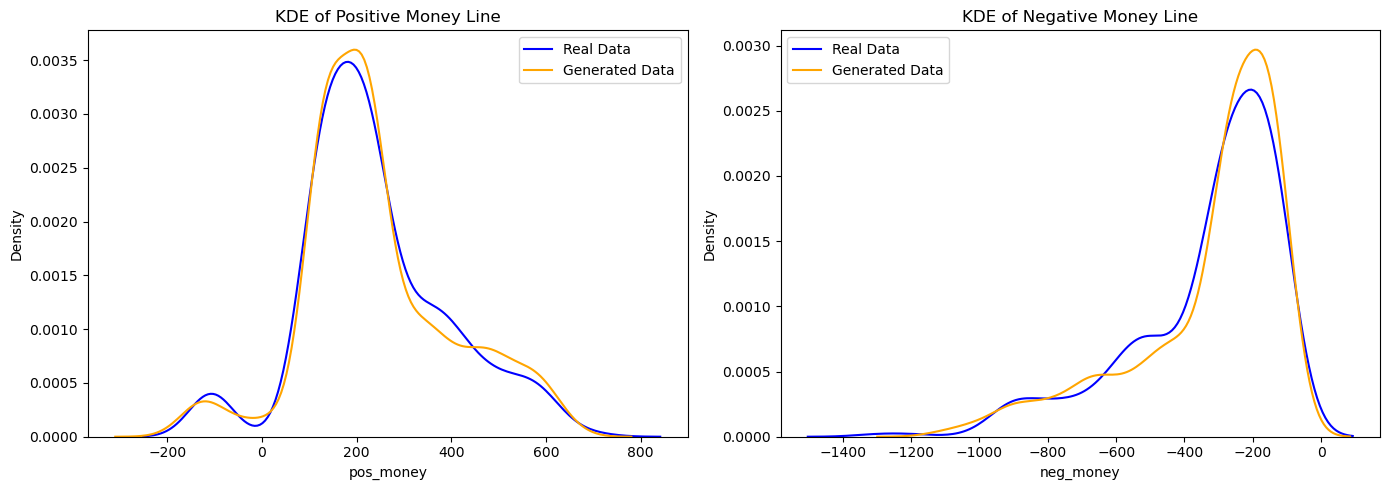

/Users/jake/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/jake/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


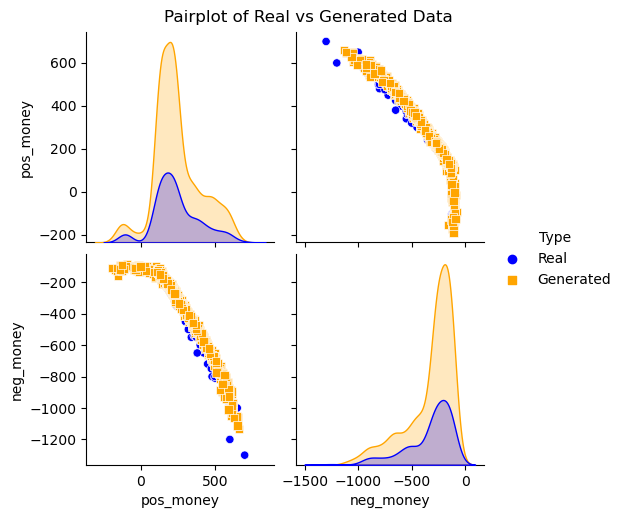

In [ ]:

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Convert generated and real data to a DataFrame for plotting
generated_samples_df = pd.DataFrame(generated_samples, columns=['pos_money', 'neg_money'])
real_data_df = pd.DataFrame(real_data_np, columns=['pos_money', 'neg_money'])

# 1. Scatter Plot - Real vs Generated Data
plt.figure(figsize=(10, 7))
plt.scatter(real_data_np[:, 0], real_data_np[:, 1], label='Real Data', color='blue', alpha=0.6)
plt.scatter(generated_samples[:, 0], generated_samples[:, 1], label='Generated Data', color='orange', alpha=0.6)
plt.title('Real Data vs. Generated Data')
plt.xlabel('Positive Money Line')
plt.ylabel('Negative Money Line')
plt.legend()
plt.show()

# 2. Histogram Comparison - Real vs Generated Data for Each Variable
fig, axs = plt.subplots(1, 2, figsize=(14, 5))
sns.histplot(real_data_df['pos_money'], kde=True, color='blue', label='Real Data', ax=axs[0])
sns.histplot(generated_samples_df['pos_money'], kde=True, color='orange', label='Generated Data', ax=axs[0])
axs[0].set_title('Distribution of Positive Money Line')
axs[0].legend()

sns.histplot(real_data_df['neg_money'], kde=True, color='blue', label='Real Data', ax=axs[1])
sns.histplot(generated_samples_df['neg_money'], kde=True, color='orange', label='Generated Data', ax=axs[1])
axs[1].set_title('Distribution of Negative Money Line')
axs[1].legend()

plt.tight_layout()
plt.show()

# 3. KDE Plot Comparison - Real vs Generated Data for Each Variable
fig, axs = plt.subplots(1, 2, figsize=(14, 5))
sns.kdeplot(real_data_df['pos_money'], color='blue', label='Real Data', ax=axs[0])
sns.kdeplot(generated_samples_df['pos_money'], color='orange', label='Generated Data', ax=axs[0])
axs[0].set_title('KDE of Positive Money Line')
axs[0].legend()

sns.kdeplot(real_data_df['neg_money'], color='blue', label='Real Data', ax=axs[1])
sns.kdeplot(generated_samples_df['neg_money'], color='orange', label='Generated Data', ax=axs[1])
axs[1].set_title('KDE of Negative Money Line')
axs[1].legend()

plt.tight_layout()
plt.show()

# 4. Pairplot to Visualize Distribution and Relationships
# Combine real and generated data for comparison in pairplot
combined_df = pd.concat([real_data_df.assign(Type='Real'), generated_samples_df.assign(Type='Generated')])
sns.pairplot(combined_df, hue='Type', markers=["o", "s"], diag_kind="kde", palette={'Real': 'blue', 'Generated': 'orange'})
plt.suptitle("Pairplot of Real vs Generated Data", y=1.02)
plt.show()

# 5. Loss Curves for Generator and Critic (if loss data was recorded during training)
# Assuming `critic_losses` and `generator_losses` are lists where each entry corresponds to the loss at each epoch
# For simplicity, here’s how you could visualize if you recorded the losses

# Uncomment the following code if you have saved the losses during the training loop:
# critic_losses = []
# generator_losses = []
# Inside the training loop, at each epoch, add:
#     critic_losses.append(loss_C.item())
#     generator_losses.append(loss_G.item())

# Sample loss plotting code:
# epochs = range(len(critic_losses))
# plt.figure(figsize=(10, 5))
# plt.plot(epochs, critic_losses, label='Critic Loss')
# plt.plot(epochs, generator_losses, label='Generator Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.title('Generator and Critic Loss Over Epochs')
# plt.legend()
# plt.show()


### Spectral Normalization Model w/ visualizations

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load your data into a pandas DataFrame
# Ensure 'df' is your DataFrame with columns 'pos_money' and 'neg_money'
# For example:
# df = pd.read_csv('your_data.csv')

# Extract the data from the DataFrame
data = df[['pos_money', 'neg_money']].values.astype(np.float32)

# (Optional) Normalize the data for better training stability
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
data = scaler.fit_transform(data)

# Convert data to PyTorch tensor
real_data = torch.tensor(data)

# Create a PyTorch dataset and dataloader
batch_size = 64  # Adjust batch size as needed
dataset = TensorDataset(real_data)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Define the Generator network with Batch Normalization and more layers
class Generator(nn.Module):
    def __init__(self, noise_dim=10, output_dim=2):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(noise_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Linear(128, output_dim),
        )

    def forward(self, z):
        return self.model(z)

# Define the Critic network with Spectral Normalization and more layers
class Critic(nn.Module):
    def __init__(self, input_dim=2):
        super(Critic, self).__init__()
        self.model = nn.Sequential(
            nn.utils.spectral_norm(nn.Linear(input_dim, 128)),
            nn.LeakyReLU(0.2, inplace=True),
            nn.utils.spectral_norm(nn.Linear(128, 256)),
            nn.LeakyReLU(0.2, inplace=True),
            nn.utils.spectral_norm(nn.Linear(256, 128)),
            nn.LeakyReLU(0.2, inplace=True),
            nn.utils.spectral_norm(nn.Linear(128, 1)),
        )

    def forward(self, x):
        return self.model(x)

# Hyperparameters
noise_dim = 10
n_epochs = 5000  # Increase epochs for better results
lr = 1e-4
n_critic = 5  # Number of critic iterations per generator iteration

# Initialize models and optimizers
device = torch.device("cpu" if torch.backends.mps.is_available() else "cpu")
G = Generator(noise_dim=noise_dim, output_dim=2).to(device)
C = Critic(input_dim=2).to(device)

optimizer_G = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.9))
optimizer_C = optim.Adam(C.parameters(), lr=lr, betas=(0.5, 0.9))

# Lists to store loss values for visualization
losses_G = []
losses_C = []

# Training loop
for epoch in range(1, n_epochs + 1):
    for i, data in enumerate(dataloader):
        real_samples = data[0].to(device)
        batch_size = real_samples.size(0)

        # Train Critic
        for _ in range(n_critic):
            z = torch.randn(batch_size, noise_dim).to(device)
            fake_samples = G(z).detach()

            critic_real = C(real_samples)
            critic_fake = C(fake_samples)

            loss_C = -(torch.mean(critic_real) - torch.mean(critic_fake))

            optimizer_C.zero_grad()
            loss_C.backward()
            optimizer_C.step()

        # Train Generator
        z = torch.randn(batch_size, noise_dim).to(device)
        fake_samples = G(z)
        critic_fake = C(fake_samples)
        loss_G = -torch.mean(critic_fake)

        optimizer_G.zero_grad()
        loss_G.backward()
        optimizer_G.step()

    # Store losses for plotting
    losses_G.append(loss_G.item())
    losses_C.append(loss_C.item())

    if epoch % 500 == 0 or epoch == 1:
        print(f"Epoch {epoch}, Loss C: {loss_C.item():.4f}, Loss G: {loss_G.item():.4f}")

Epoch 1, Loss C: -0.0870, Loss G: -0.0021
Epoch 500, Loss C: -0.0100, Loss G: -0.1155
Epoch 1000, Loss C: -0.0057, Loss G: -0.0533
Epoch 1500, Loss C: -0.0056, Loss G: -0.0597
Epoch 2000, Loss C: -0.0030, Loss G: -0.0804
Epoch 2500, Loss C: -0.0067, Loss G: -0.0871
Epoch 3000, Loss C: -0.0064, Loss G: -0.0799
Epoch 3500, Loss C: -0.0041, Loss G: -0.0797
Epoch 4000, Loss C: -0.0021, Loss G: -0.0855
Epoch 4500, Loss C: -0.0027, Loss G: -0.1041
Epoch 5000, Loss C: -0.0031, Loss G: -0.1309


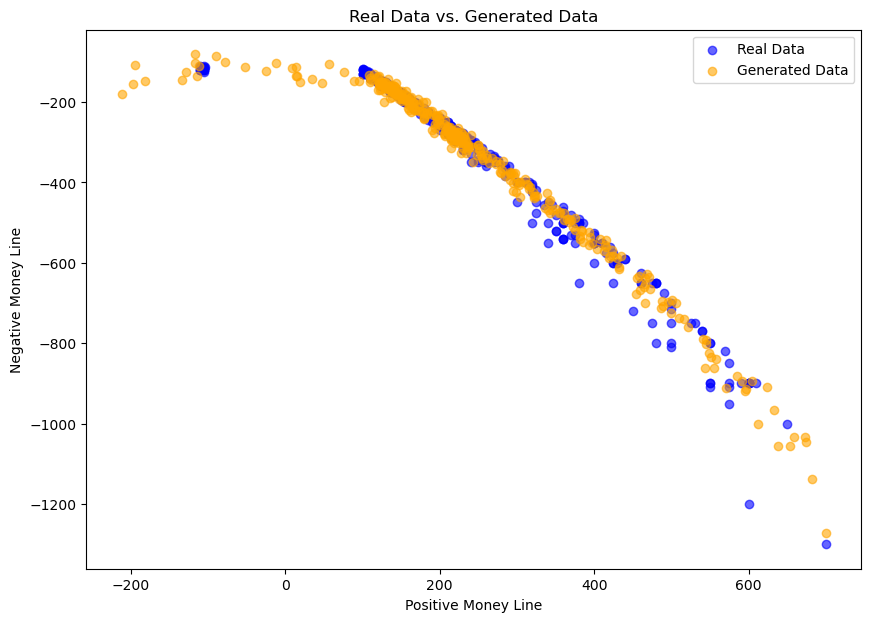

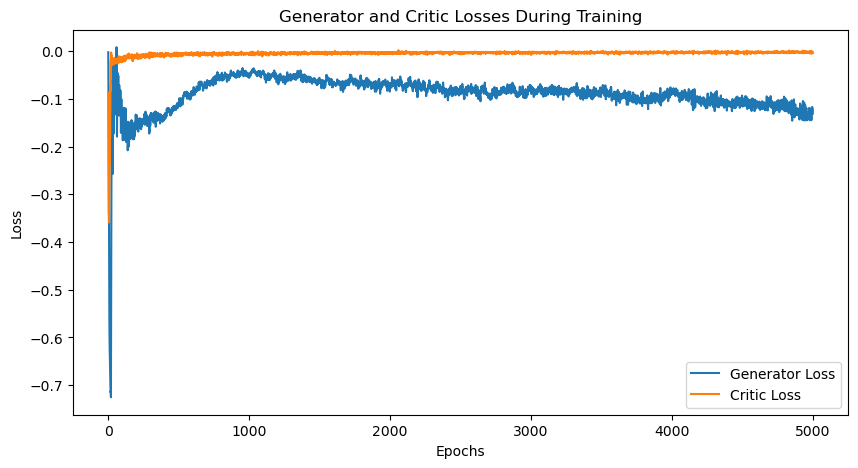

/Users/jake/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/jake/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/jake/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/jake/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version

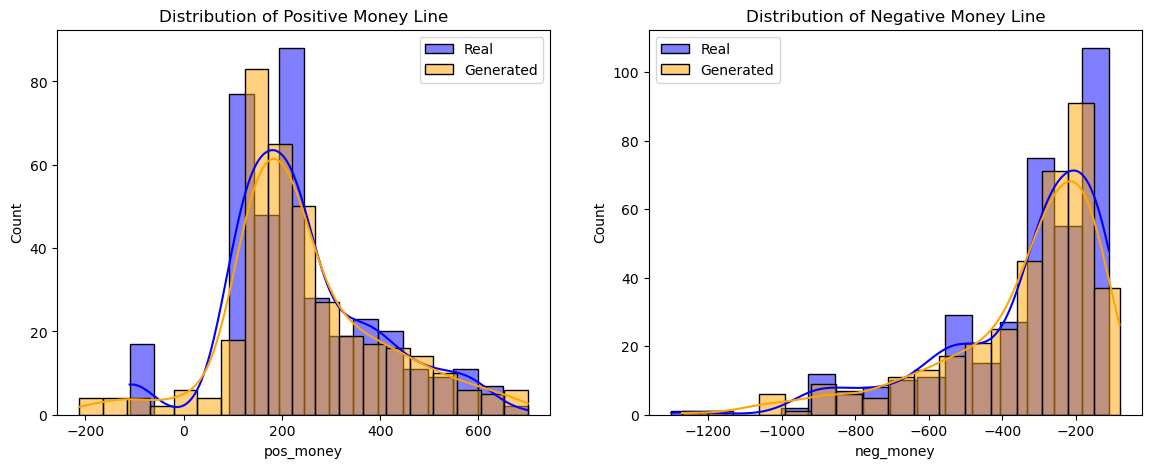

/Users/jake/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/jake/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/jake/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/jake/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version

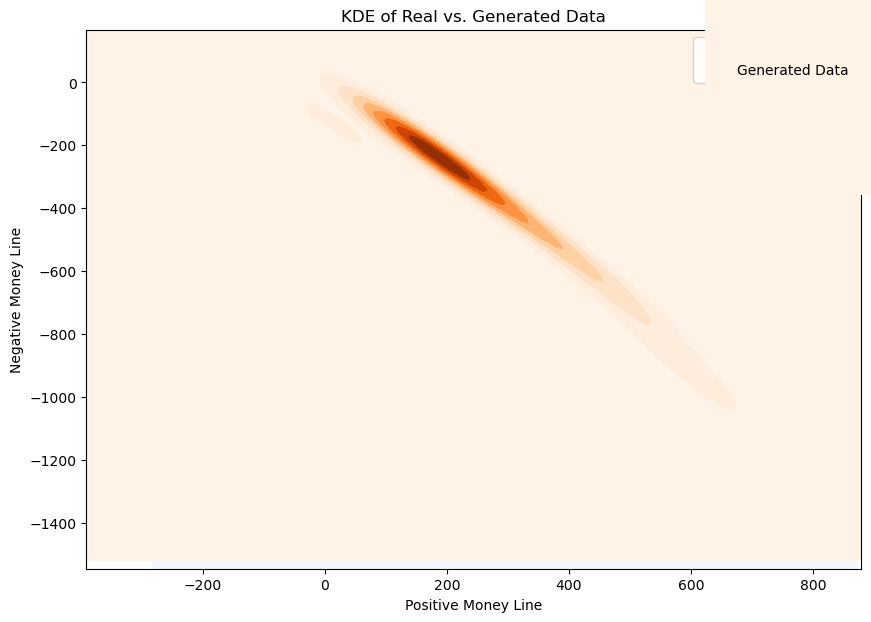

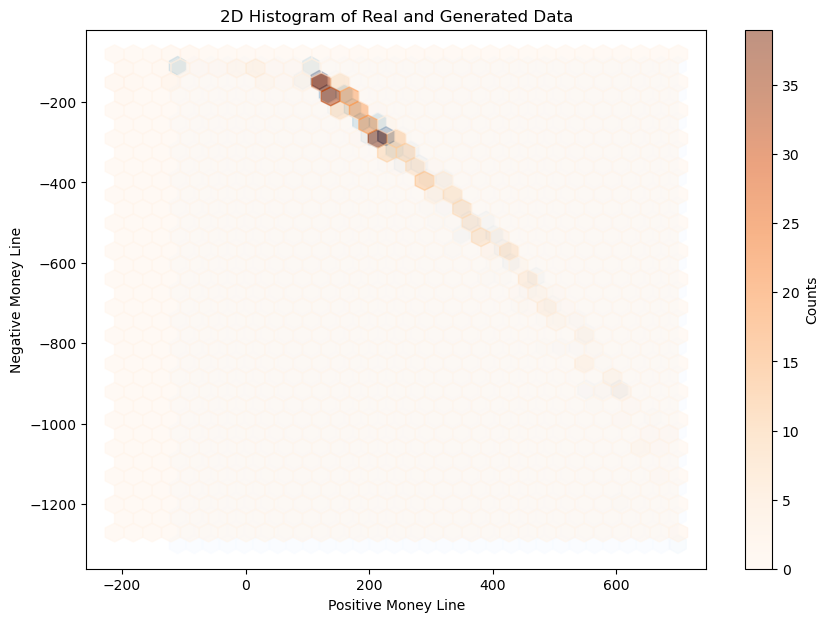

KS Test for 'pos_money': KS Statistic = 0.0667, p-value = 0.4009
KS Test for 'neg_money': KS Statistic = 0.0833, p-value = 0.1642


In [14]:
# Generate synthetic data
with torch.no_grad():
    z = torch.randn(len(real_data), noise_dim).to(device)
    generated_samples = G(z).cpu().numpy()

# Inverse transform the data if normalized
generated_samples = scaler.inverse_transform(generated_samples)
real_data_np = scaler.inverse_transform(real_data.numpy())

# Convert to DataFrames for easier plotting
real_df = pd.DataFrame(real_data_np, columns=['pos_money', 'neg_money'])
gen_df = pd.DataFrame(generated_samples, columns=['pos_money', 'neg_money'])

# Plot real data vs. generated data
plt.figure(figsize=(10, 7))
plt.scatter(real_df['pos_money'], real_df['neg_money'], label='Real Data', color='blue', alpha=0.6)
plt.scatter(gen_df['pos_money'], gen_df['neg_money'], label='Generated Data', color='orange', alpha=0.6)
plt.title('Real Data vs. Generated Data')
plt.xlabel('Positive Money Line')
plt.ylabel('Negative Money Line')
plt.legend()
plt.show()

# Plot Generator and Critic Losses
plt.figure(figsize=(10, 5))
plt.plot(losses_G, label='Generator Loss')
plt.plot(losses_C, label='Critic Loss')
plt.title('Generator and Critic Losses During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot histograms of individual features
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.histplot(real_df['pos_money'], kde=True, color='blue', label='Real', ax=axes[0])
sns.histplot(gen_df['pos_money'], kde=True, color='orange', label='Generated', ax=axes[0])
axes[0].set_title('Distribution of Positive Money Line')
axes[0].legend()

sns.histplot(real_df['neg_money'], kde=True, color='blue', label='Real', ax=axes[1])
sns.histplot(gen_df['neg_money'], kde=True, color='orange', label='Generated', ax=axes[1])
axes[1].set_title('Distribution of Negative Money Line')
axes[1].legend()
plt.show()

# Plot KDE of the joint distribution
plt.figure(figsize=(10, 7))
sns.kdeplot(data=real_df, x='pos_money', y='neg_money', cmap='Blues', fill=True, thresh=0, levels=10, label='Real Data')
sns.kdeplot(data=gen_df, x='pos_money', y='neg_money', cmap='Oranges', fill=True, thresh=0, levels=10, label='Generated Data')
plt.title('KDE of Real vs. Generated Data')
plt.xlabel('Positive Money Line')
plt.ylabel('Negative Money Line')
plt.legend()
plt.show()

# 2D Histogram (Hexbin Plot)
plt.figure(figsize=(10, 7))
plt.hexbin(real_df['pos_money'], real_df['neg_money'], gridsize=30, cmap='Blues', alpha=0.5, label='Real Data')
plt.hexbin(gen_df['pos_money'], gen_df['neg_money'], gridsize=30, cmap='Oranges', alpha=0.5, label='Generated Data')
plt.title('2D Histogram of Real and Generated Data')
plt.xlabel('Positive Money Line')
plt.ylabel('Negative Money Line')
plt.colorbar(label='Counts')
plt.show()

# Statistical Comparison: Kolmogorov-Smirnov Test
from scipy.stats import ks_2samp

ks_stat_pos, p_value_pos = ks_2samp(real_df['pos_money'], gen_df['pos_money'])
ks_stat_neg, p_value_neg = ks_2samp(real_df['neg_money'], gen_df['neg_money'])

print(f"KS Test for 'pos_money': KS Statistic = {ks_stat_pos:.4f}, p-value = {p_value_pos:.4f}")
print(f"KS Test for 'neg_money': KS Statistic = {ks_stat_neg:.4f}, p-value = {p_value_neg:.4f}")


# Spectral Normalization, Larger Network

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load your data into a pandas DataFrame
# Ensure 'df' is your DataFrame with columns 'pos_money' and 'neg_money'
# For example:
# df = pd.read_csv('your_data.csv')

# For demonstration purposes, let's create a sample DataFrame
# Remove this and load your actual data
# data_sample = {
#     'pos_money': np.random.randint(100, 500, size=360),
#     'neg_money': np.random.randint(-550, -200, size=360)
# }
# df = pd.DataFrame(data_sample)

# Extract the data from the DataFrame
data = df[['pos_money', 'neg_money']].values.astype(np.float32)

# (Optional) Normalize the data for better training stability
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
data = scaler.fit_transform(data)

# Convert data to PyTorch tensor
real_data = torch.tensor(data)

# Create a PyTorch dataset and dataloader
batch_size = 64  # Adjust batch size as needed
dataset = TensorDataset(real_data)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Define the Generator network with Batch Normalization, Dropout, and more layers
class Generator(nn.Module):
    def __init__(self, noise_dim=10, output_dim=2):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(noise_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, output_dim),
        )

    def forward(self, z):
        return self.model(z)

# Define the Critic network with Spectral Normalization, Dropout, and more layers
class Critic(nn.Module):
    def __init__(self, input_dim=2):
        super(Critic, self).__init__()
        self.model = nn.Sequential(
            nn.utils.spectral_norm(nn.Linear(input_dim, 256)),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.utils.spectral_norm(nn.Linear(256, 512)),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.utils.spectral_norm(nn.Linear(512, 256)),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.utils.spectral_norm(nn.Linear(256, 1)),
        )

    def forward(self, x):
        return self.model(x)

# Hyperparameters
noise_dim = 10
n_epochs = 5000  # Increase epochs for better results
lr = 1e-4
n_critic = 5  # Number of critic iterations per generator iteration

# Initialize models and optimizers
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
if device.type == 'cuda':
    print("GPU:", torch.cuda.get_device_name(0))
G = Generator(noise_dim=noise_dim, output_dim=2).to(device)
C = Critic(input_dim=2).to(device)

optimizer_G = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.9))
optimizer_C = optim.Adam(C.parameters(), lr=lr, betas=(0.5, 0.9))

# Lists to store loss values for visualization
losses_G = []
losses_C = []

# Training loop
for epoch in range(1, n_epochs + 1):
    for i, data_batch in enumerate(dataloader):
        real_samples = data_batch[0].to(device)
        batch_size = real_samples.size(0)

        # Train Critic
        for _ in range(n_critic):
            z = torch.randn(batch_size, noise_dim).to(device)
            fake_samples = G(z).detach()

            critic_real = C(real_samples)
            critic_fake = C(fake_samples)

            loss_C = -(torch.mean(critic_real) - torch.mean(critic_fake))

            optimizer_C.zero_grad()
            loss_C.backward()
            optimizer_C.step()

        # Train Generator
        z = torch.randn(batch_size, noise_dim).to(device)
        fake_samples = G(z)
        critic_fake = C(fake_samples)
        loss_G = -torch.mean(critic_fake)

        optimizer_G.zero_grad()
        loss_G.backward()
        optimizer_G.step()

    # Store losses for plotting
    losses_G.append(loss_G.item())
    losses_C.append(loss_C.item())

    if epoch % 500 == 0 or epoch == 1:
        print(f"Epoch {epoch}, Loss C: {loss_C.item():.4f}, Loss G: {loss_G.item():.4f}")

# Generate synthetic data
with torch.no_grad():
    z = torch.randn(len(real_data), noise_dim).to(device)
    generated_samples = G(z).cpu().numpy()

# Inverse transform the data if normalized
generated_samples = scaler.inverse_transform(generated_samples)
real_data_np = scaler.inverse_transform(real_data.numpy())

# Convert to DataFrames for easier plotting
real_df = pd.DataFrame(real_data_np, columns=['pos_money', 'neg_money'])
gen_df = pd.DataFrame(generated_samples, columns=['pos_money', 'neg_money'])



Using device: cpu
Epoch 1, Loss C: -0.2174, Loss G: -0.2218
Epoch 500, Loss C: -0.0096, Loss G: -0.0836
Epoch 1000, Loss C: -0.0185, Loss G: -0.0712
Epoch 1500, Loss C: 0.0072, Loss G: -0.0928
Epoch 2000, Loss C: -0.0060, Loss G: -0.0877
Epoch 2500, Loss C: 0.0093, Loss G: -0.0711
Epoch 3000, Loss C: -0.0032, Loss G: 0.0518
Epoch 3500, Loss C: -0.0007, Loss G: -0.0367
Epoch 4000, Loss C: 0.0288, Loss G: -0.1322
Epoch 4500, Loss C: -0.0191, Loss G: -0.1139
Epoch 5000, Loss C: 0.0184, Loss G: -0.2367


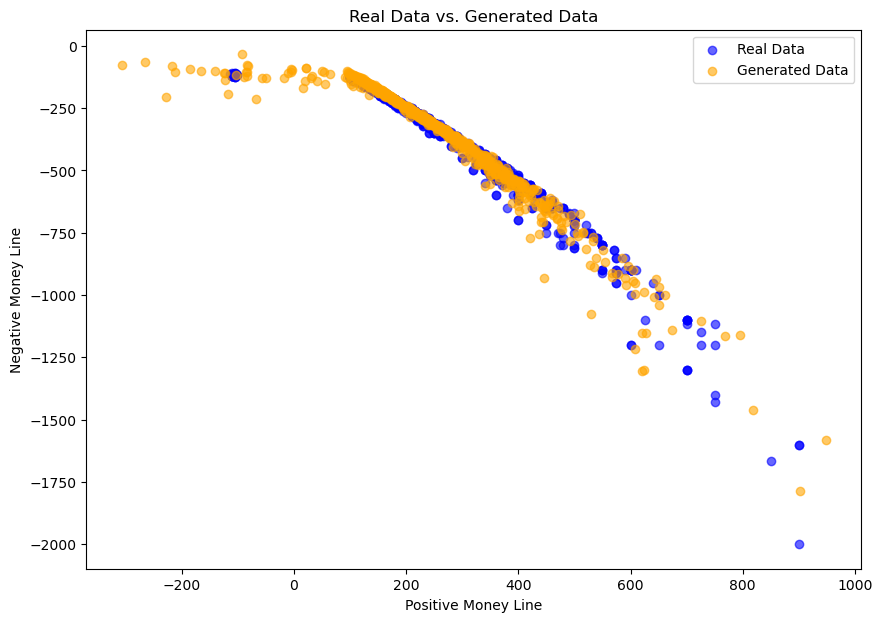

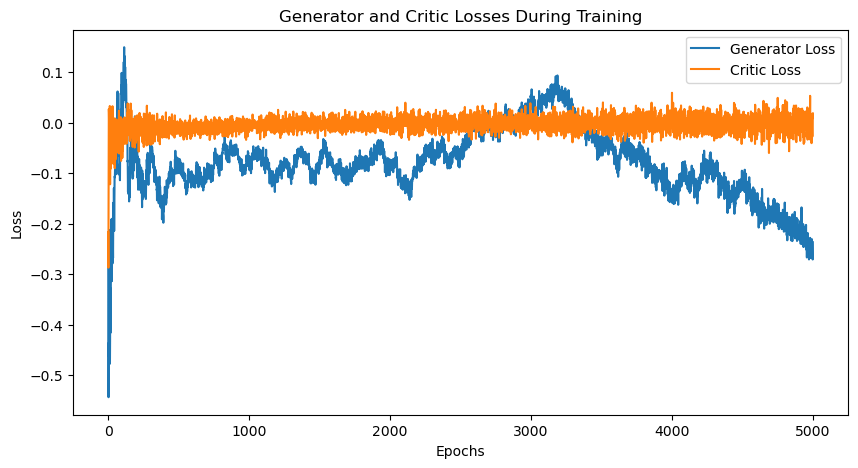

/Users/jake/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/jake/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/jake/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/jake/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version

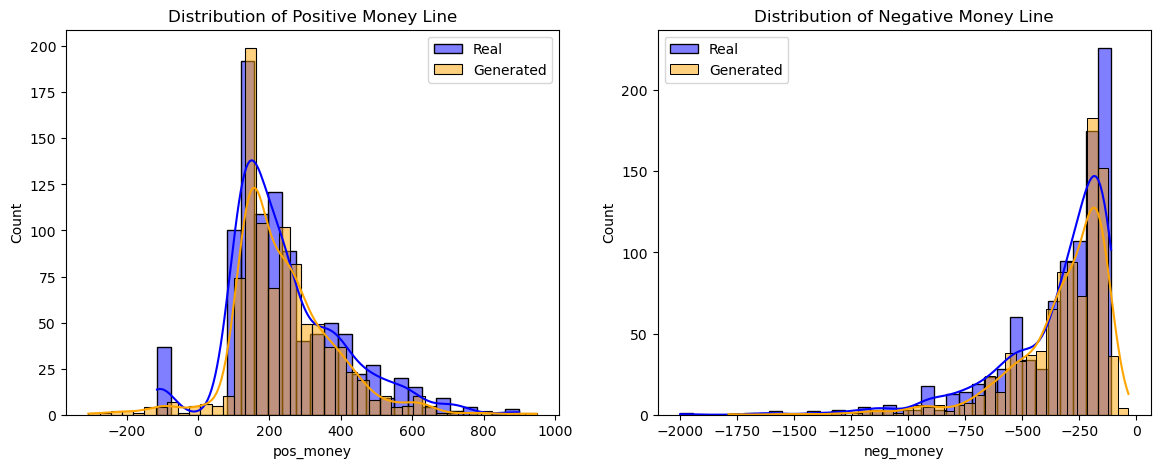

/Users/jake/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/jake/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/jake/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/jake/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version

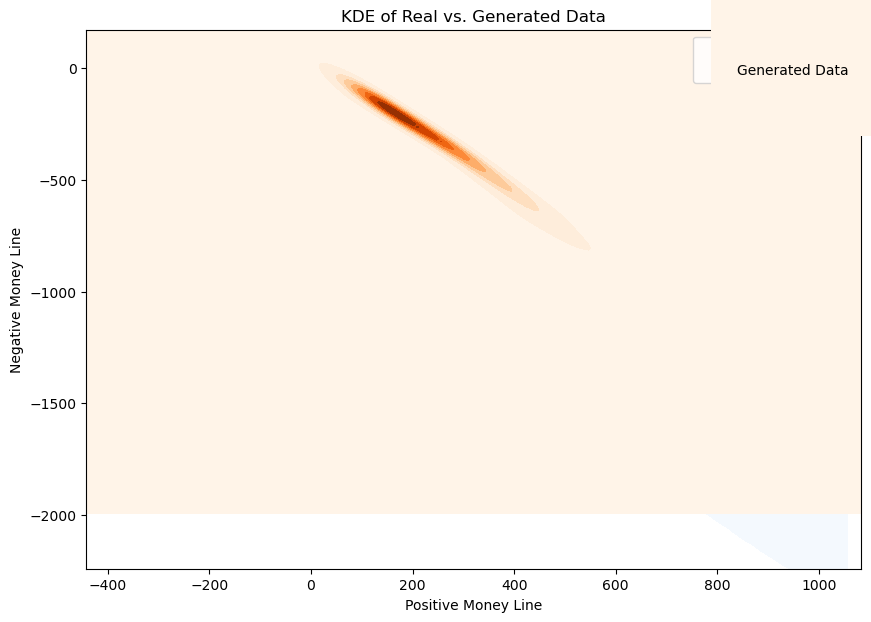

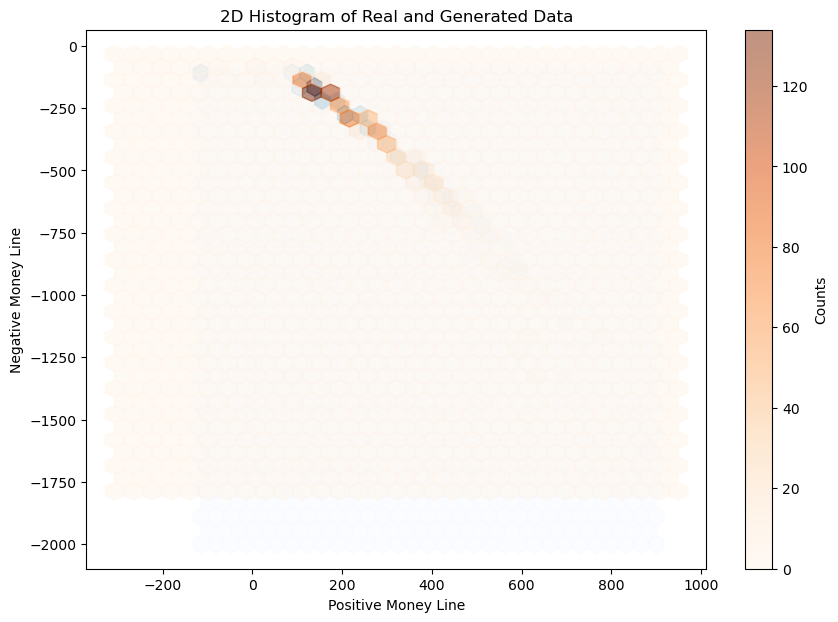

KS Test for 'pos_money': KS Statistic = 0.1008, p-value = 0.0001
KS Test for 'neg_money': KS Statistic = 0.0775, p-value = 0.0070


In [5]:
# Plot real data vs. generated data
plt.figure(figsize=(10, 7))
plt.scatter(real_df['pos_money'], real_df['neg_money'], label='Real Data', color='blue', alpha=0.6)
plt.scatter(gen_df['pos_money'], gen_df['neg_money'], label='Generated Data', color='orange', alpha=0.6)
plt.title('Real Data vs. Generated Data')
plt.xlabel('Positive Money Line')
plt.ylabel('Negative Money Line')
plt.legend()
plt.show()

# Plot Generator and Critic Losses
plt.figure(figsize=(10, 5))
plt.plot(losses_G, label='Generator Loss')
plt.plot(losses_C, label='Critic Loss')
plt.title('Generator and Critic Losses During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot histograms of individual features
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.histplot(real_df['pos_money'], kde=True, color='blue', label='Real', ax=axes[0])
sns.histplot(gen_df['pos_money'], kde=True, color='orange', label='Generated', ax=axes[0])
axes[0].set_title('Distribution of Positive Money Line')
axes[0].legend()

sns.histplot(real_df['neg_money'], kde=True, color='blue', label='Real', ax=axes[1])
sns.histplot(gen_df['neg_money'], kde=True, color='orange', label='Generated', ax=axes[1])
axes[1].set_title('Distribution of Negative Money Line')
axes[1].legend()
plt.show()

# Plot KDE of the joint distribution
plt.figure(figsize=(10, 7))
sns.kdeplot(data=real_df, x='pos_money', y='neg_money', cmap='Blues', fill=True, thresh=0, levels=10, label='Real Data')
sns.kdeplot(data=gen_df, x='pos_money', y='neg_money', cmap='Oranges', fill=True, thresh=0, levels=10, label='Generated Data')
plt.title('KDE of Real vs. Generated Data')
plt.xlabel('Positive Money Line')
plt.ylabel('Negative Money Line')
plt.legend()
plt.show()

# 2D Histogram (Hexbin Plot)
plt.figure(figsize=(10, 7))
plt.hexbin(real_df['pos_money'], real_df['neg_money'], gridsize=30, cmap='Blues', alpha=0.5)
plt.hexbin(gen_df['pos_money'], gen_df['neg_money'], gridsize=30, cmap='Oranges', alpha=0.5)
plt.title('2D Histogram of Real and Generated Data')
plt.xlabel('Positive Money Line')
plt.ylabel('Negative Money Line')
plt.colorbar(label='Counts')
plt.show()

# Statistical Comparison: Kolmogorov-Smirnov Test
from scipy.stats import ks_2samp

ks_stat_pos, p_value_pos = ks_2samp(real_df['pos_money'], gen_df['pos_money'])
ks_stat_neg, p_value_neg = ks_2samp(real_df['neg_money'], gen_df['neg_money'])

print(f"KS Test for 'pos_money': KS Statistic = {ks_stat_pos:.4f}, p-value = {p_value_pos:.4f}")
print(f"KS Test for 'neg_money': KS Statistic = {ks_stat_neg:.4f}, p-value = {p_value_neg:.4f}")
